## PreProcess Images and feed into CNN

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
# Install package to handle .tiff data
!pip install pyrsgis

In [8]:
# Clone my git repo for preprocessing the images

#!git clone https://github.com/maxjonasbehrens/master_thesis_code
%cd /content/master_thesis_code
!git pull

/content/master_thesis_code
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 10 (delta 5), reused 10 (delta 5), pack-reused 0
Unpacking objects: 100% (10/10), done.
From https://github.com/maxjonasbehrens/master_thesis_code
   4161480..3bd8f54  master     -> origin/master
Updating 4161480..3bd8f54
Fast-forward
 NeuralNetTrain/imgProcessing/sat_images.py | 143 ++++++++++++++++++++++++++++-
 1 file changed, 142 insertions(+), 1 deletion(-)


In [0]:
# Load Python script for preprocessing
%load /content/master_thesis_code/NeuralNetTrain/imgProcessing/sat_images.py

In [0]:
# Load necessary packages
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import pyrsgis
import cv2
from skimage.transform import resize
from PIL import Image
%matplotlib inline 
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join
import scipy.io
import sklearn.model_selection

In [0]:
# Import own module to preprocess images
import imp
sat_images = imp.new_module('sat_images')
exec(open("/content/master_thesis_code/NeuralNetTrain/imgProcessing/sat_images.py").read(), sat_images.__dict__)

## Test for one image

In [0]:
# Download test image from drive
img_path = "/gdrive/My Drive/nuts_geotiff/BE34_2013.tif"

ds1, img = pyrsgis.raster.read(img_path)

In [0]:
# Print its shape
print("Image shape: ",img.shape)

Image shape:  (3, 1299, 1482)


In [0]:
# Resize original image to compatible size
img = np.swapaxes(img,0,-1)
orig_resized = resize(img, (1024,1024))

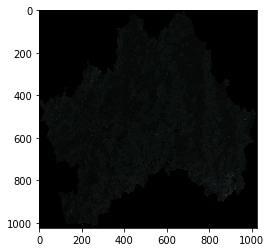

In [0]:
# Show the original image
plt.imshow(orig_resized, interpolation='nearest')
plt.show()

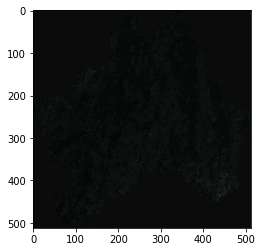

In [0]:
# Test replacing nan values with mean or samples from normal distribution

mu, sigma = np.nanmean(img), np.nanstd(img)
processed_img = img
#processed_img = resize(processed_img, (512,512))
n_nan = len(processed_img[np.isnan(processed_img)])
processed_img[np.isnan(processed_img)] = mu#np.random.normal(mu,sigma,n_nan)
processed_img = resize(processed_img, (512,512))
plt.imshow(processed_img, interpolation='nearest')
plt.show()

# Create input data

In [12]:
# Load Data Frame of NUTS regions and corresponding gdp values
y_dat = pd.read_csv("/gdrive/My Drive/ThesisData/Data/enhanced_gdp_data.csv")
y_dat.head()

,nuts2,year,nuts_value,code,country,country_value,mean_value,diff_value
0,BE10,2008,61100.0,BE,Belgium,33100.0,31881.818182,28000.0
1,BE21,2008,39200.0,BE,Belgium,33100.0,31881.818182,6100.0
2,BE22,2008,27500.0,BE,Belgium,33100.0,31881.818182,-5600.0
3,BE23,2008,29400.0,BE,Belgium,33100.0,31881.818182,-3700.0
4,BE24,2008,34500.0,BE,Belgium,33100.0,31881.818182,1400.0


In [8]:
# Benchmark for diff-value (other benchmark are in other script)
mae_diff = np.mean(abs(y_dat['diff_value']-y_dat['diff_value'].mean()))
print(mae_diff)

5478.004371660496


In [0]:
# List of all files in directory of images
mypath = "/gdrive/My Drive/nuts_night/"
mypath_day = "/gdrive/My Drive/nuts_geotiff/"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [0]:
# PreProcess images with certain resolution
res = 64
x,y,label = sat_images.create_data(onlyfiles[1:],mypath_day,y_dat,prediction='nuts_value',replace_nan='mean',resolution=res,night=False)
scipy.io.savemat("/gdrive/My Drive/ThesisData/Data/data_day_mean_64_merge.mat", mdict={'x': x}, oned_as='row')

In [0]:
# PreProcess subsample data from raw images
res = 64
y_dat = pd.read_csv("/gdrive/My Drive/ThesisData/Data/enhanced_gdp_data.csv")
mypath = "/gdrive/My Drive/nuts_day_raw/"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
x,y,label = sat_images.create_sample_data(onlyfiles,mypath,y_dat,resolution=res)

Image processed:  0  of  127
Image processed:  10  of  127
Image processed:  20  of  127
Image processed:  30  of  127
Image processed:  40  of  127
Image processed:  50  of  127
Image processed:  60  of  127
Image processed:  70  of  127
Image processed:  80  of  127


In [0]:
x.tofile
y.tofile
label.tofile

### Save NIGHT images

In [0]:
# Save ndarray to reproduce in drive for NIGHT images
scipy.io.savemat("/gdrive/My Drive/ThesisData/Data/data_night_mean_64.mat", mdict={'x': x}, oned_as='row')

### Save DAY images

In [0]:
# Save ndarray to reproduce in drive for DAY images
scipy.io.savemat("/gdrive/My Drive/ThesisData/Data/data_day_mean_64.mat", mdict={'x': x}, oned_as='row')
#scipy.io.savemat("/gdrive/My Drive/ThesisData/Data/data_day_mean_512_2.mat", mdict={'x': x[600:]}, oned_as='row')

In [0]:
# Load input from scratch

# For DAY images
#x = np.vstack((scipy.io.loadmat("/gdrive/My Drive/ThesisData/Data/data_day_mean_512_1.mat")['x'],scipy.io.loadmat("/gdrive/My Drive/ThesisData/Data/data_day_mean_512_2.mat")['x']))

# For NIGHT images
x = scipy.io.loadmat("/gdrive/My Drive/ThesisData/Data/data_night_mean_512.mat")['x']

y, label = sat_images.create_y_label(onlyfiles,mypath,y_dat,prediction='nuts_value')

In [0]:
# Print shape of images
print('Shape of x: ',len(x))
print('Shape of y: ',len(y))
print('Shape of labels: ', len(label))

Shape of x:  692
Shape of y:  692
Shape of labels:  692


In [0]:
# Convert grayscale 1-channel to 3-channel (only for transfer learning)
x = np.stack((x,)*3, axis=-1)
print(x.shape)

(692, 512, 512, 3)


## Sample CNN Architectures

In [0]:
# Very shallow CNN
model = Sequential()
model.add(Conv2D(32, 3, padding='same', input_shape=in_shape, activation='relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(units=out_shape,activation='relu'))

In [0]:
# Fully connected model
model = Sequential()
model.add(Flatten(input_shape=x_train.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='relu'))

In [0]:
# Deep Model
model = Sequential()

model.add(Conv2D(32, 3, padding='same', input_shape=in_shape, activation='relu'))
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(128, 3, padding='same', activation='relu'))
model.add(Conv2D(128, 3, padding='same', activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(256, 3, padding='same', activation='relu'))
model.add(Conv2D(256, 3, padding='same', activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(512, 3, padding='same', activation='relu'))
model.add(Conv2D(512, 3, padding='same', activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dense(256, activation='relu', activity_regularizer=l1(0.001)))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu',activity_regularizer=l1(0.001)))
model.add(Dropout(0.5))
model.add(Dense(units=out_shape,activation='relu'))

In [0]:
# Shallow Model
model = tf.keras.Sequential()

model.add(Conv2D(16, 3, padding='same', input_shape=in_shape, activation='relu'))
model.add(Conv2D(16, 3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='normal', activity_regularizer=l1(0.001)))
model.add(Dropout(0.5))
model.add(Dense(units=out_shape, kernel_initializer='normal',activation='relu'))

In [0]:
# Transfer Learning
base_model = ResNet50(input_shape=in_shape,include_top=False)
	x=base_model.output
	x=Flatten()(x)
	x=Dense(32,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
	x=Dropout(0.2)(x) #Dropout
	x=Dense(32,activation='relu')(x) #dense layer 3
	x=Dropout(0.2)(x) #Dropout
	preds=Dense(units=out_shape, activation = 'relu')(x)
	model=Model(inputs=base_model.input,outputs=preds)
 
	for layer in model.layers[:156]:
  	layer.trainable = False


94658560/94653016 [==============================] - 7s 0us/step


In [0]:
# dense layers much less

# Training Pipeline for CNN Fitting

In [13]:
from numpy import load
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, AveragePooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.regularizers import l1, l2, l1_l2
from keras.optimizers import SGD, Adam
from keras.applications import VGG16, ResNet50, ResNet50V2, InceptionResNetV2
from keras.callbacks import EarlyStopping
import scipy
import pandas as pd
import numpy as np
from datetime import date
from os import listdir
from os.path import isfile, join

Using TensorFlow backend.


In [0]:
# split into train, validation and test dataset
def data_split(x, y, label, test_size=0.2, one_d = False):
  
  np.random.seed(42)

  # Create list of unique regions
  regions = []
  for i in range(len(label)):
    regions.append(label[i].rsplit('_',1)[0])

  regions = np.unique(regions)

  # Split regions into train and test set
  msk_test = np.random.rand(len(regions)) < test_size

  train_split = regions[~msk_test]
  test_split = regions[msk_test]

  msk_val = np.random.rand(len(train_split)) < (test_size+0.05)

  val_split = train_split[msk_val]
  train_split = train_split[~msk_val]

  # Split whole data set into test and train based on split regions
  import math
  label_train = []
  label_val = []
  label_test = []
  x_train = []
  y_train = []
  x_val = []
  y_val = []
  x_test = []
  y_test = []

  # Split into train and test based on previous region split
  for i in range(len(label)):
    if label[i].rsplit('_',1)[0] in train_split:
      if math.isnan(y[i]):
        pass
      else:
        label_train.append(label[i])
        x_train.append(x[i])
        y_train.append(int(y[i]))
    elif label[i].rsplit('_',1)[0] in val_split:
      if math.isnan(y[i]):
        pass
      else:
        label_val.append(label[i])
        x_val.append(x[i])
        y_val.append(int(y[i]))
    else:
      if math.isnan(y[i]):
        pass
      else:
        label_test.append(label[i])
        x_test.append(x[i])
        y_test.append(int(y[i]))

  # Transform into numpy array
  label_train = np.array(label_train)
  label_test = np.array(label_test)
  label_val = np.array(label_val)
  #x_train = np.array(x_train)
  #x_test = np.array(x_test)
  #x_val = np.array(x_val)
  y_train = np.array(y_train)
  y_test = np.array(y_test)  
  y_val = np.array(y_val)

  if one_d:
    x_train = np.array([x_train])
    x_train = np.moveaxis(x_train,0,-1)
    x_val = np.array([x_val])
    x_val = np.moveaxis(x_val,0,-1)
    x_test = np.array([x_test])
    x_test = np.moveaxis(x_test,0,-1)

  return x_train, x_val, x_test, y_train, y_val, y_test, label_train, label_val, label_test


In [0]:
# Feature to combine night and day images into one 4-channel image
def combine_img():
  mypath_night = "/gdrive/My Drive/nuts_night/"
  onlyfiles_night = [f for f in listdir(mypath_night) if isfile(join(mypath_night, f))]

  y_dat = pd.read_csv("/gdrive/My Drive/ThesisData/Data/enhanced_gdp_data.csv")

  y, label = sat_images.create_y_label(onlyfiles_night,mypath_night,y_dat,prediction='nuts_value')

  x_day = scipy.io.loadmat("/gdrive/My Drive/ThesisData/Data/data_day_mean_64_merge.mat")['x']
  x_night = scipy.io.loadmat("/gdrive/My Drive/ThesisData/Data/data_night_mean_64.mat")['x']
  x_night = x_night[1:]

  x_night = np.array([x_night])
  x_night = np.moveaxis(x_night,0,-1)

  #print(x_day.shape)
  #print(x_night.shape)

  x = np.append(x_day,x_night,axis=3)
  #print(x.shape)

  return x,y[1:],label[1:]

In [0]:
# load train and test dataset
def load_dataset(filepath = "/gdrive/My Drive/ThesisData/Data/data_night_mean_512.mat", 
                 mypath = "/gdrive/My Drive/nuts_day_raw/" ,
                 one_d = False, 
                 four_d = False, 
                 subselect = False,
                 res = 256):
	# Load Data Frame of NUTS regions and corresponding gdp values
  y_dat = pd.read_csv("/gdrive/My Drive/ThesisData/Data/enhanced_gdp_data.csv")
  # List of all files in directory of images
  mypath = mypath
  onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

  # load dataset
  if four_d:
    x,y,label = combine_img()
  elif subselect:
    x,y,label = sat_images.create_sample_data(onlyfiles,mypath,y_dat,resolution=res)
  else:
    x = scipy.io.loadmat(filepath)['x']
    y, label = sat_images.create_y_label(onlyfiles,mypath,y_dat,prediction='nuts_value')  

  if (one_d == False) & (four_d == False) & (subselect == False):
    # Convert grayscale 1-channel to 3-channel (only for transfer learning)
    x = np.stack((x,)*3, axis=-1)
	
  # separate into train and test datasets
  x_train, x_val, x_test, y_train, y_val, y_test, label_train, label_val, label_test = data_split(x, y, label, test_size=0.2, one_d = one_d)
	
  return x_train, x_val, x_test, y_train, y_val, y_test, label_train, label_val, label_test

In [0]:
# define cnn model
def define_model(lr,in_shape=(512, 512, 3), out_shape=1):
	
	# Deep Model
	model = Sequential()

	model.add(Conv2D(32, 3, padding='same', input_shape=in_shape, activation='relu'))
	model.add(Conv2D(32, 3, padding='same', activation='relu'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D(pool_size = (2,2)))

	model.add(Conv2D(64, 3, padding='same', activation='relu'))
	model.add(Conv2D(64, 3, padding='same', activation='relu'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D(pool_size = (2,2)))

	model.add(Conv2D(128, 3, padding='same', activation='relu'))
	model.add(Conv2D(128, 3, padding='same', activation='relu'))
	model.add(Dropout(0.4))
	model.add(BatchNormalization())
	model.add(MaxPooling2D(pool_size = (2,2)))

	model.add(Conv2D(256, 3, padding='same', activation='relu'))
	model.add(Conv2D(256, 3, padding='same', activation='relu'))
	model.add(Dropout(0.4))
	model.add(BatchNormalization())
	model.add(MaxPooling2D(pool_size = (2,2)))

	model.add(Conv2D(512, 3, padding='same', activation='relu'))
	model.add(Conv2D(512, 3, padding='same', activation='relu'))
	model.add(Dropout(0.4))
	model.add(BatchNormalization())
	model.add(MaxPooling2D(pool_size = (2,2)))

	model.add(Flatten())
	model.add(Dense(256, activation='relu', activity_regularizer=l1(0.001)))
	model.add(Dropout(0.5))

	model.add(Dense(256, activation='relu',activity_regularizer=l1(0.001)))
	model.add(Dropout(0.5))
	model.add(Dense(units=out_shape,activation='relu'))
	
	# compile model
	opt = Adam(lr=lr)
	model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mse','mae'])
 
	return model

In [0]:
# plot diagnostic learning curves
def summarize_diagnostics(history,no_layers,in_shape,batch_size,epochs,mse,mae,transfer,lr,optim,comment):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Model MSE')
	pyplot.plot(history.history['mean_squared_error'], color='blue', label='train')
	pyplot.plot(history.history['val_mean_squared_error'], color='orange', label='val')
	pyplot.xlabel("")
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Model MAE')
	pyplot.plot(history.history['mean_absolute_error'], color='blue', label='train')
	pyplot.plot(history.history['val_mean_absolute_error'], color='orange', label='val')
	# save plot to file
	day = date.today()
	filename = str(day)+"_"+str(in_shape[0])+"_"+str(in_shape[2])+"_"+str(epochs)+"_"+str(batch_size)
	pyplot.savefig('/gdrive/My Drive/ThesisData/cnn_results/'+filename + '_plot.png')
	pyplot.close()
  
	# write diagnostics to results file
	myrow = ['\n'+str(day),str(no_layers),str(batch_size),str(epochs),str(in_shape[0]),str(in_shape[2]),
	         str(history.history['mean_squared_error'][-1]),str(history.history['mean_absolute_error'][-1]),
					     str(history.history['val_mean_squared_error'][-1]),str(history.history['val_mean_absolute_error'][-1]),
							   str(mse),str(mae),str(transfer),str(lr),str(optim),str(comment)]
	myrow = ','.join(myrow)
	filepath = '/gdrive/My Drive/ThesisData/cnn_results/cnn_results.csv'
	with open(filepath,'a') as fd:
		fd.write(myrow)

In [0]:
# run the test harness for evaluating a model
def run_test_harness(comment,transfer,optim,lr=0.0001,batch_size = 10,epochs = 50, in_shape = (512,512,3), subselect = False):
  
  if in_shape[2] == 1:
    one_d = True
    four_d = False
  elif in_shape[2] == 4:
    four_d = True
    one_d = False
  else:
    one_d = False
    four_d = False
  
  # load dataset
  x_train, x_val, x_test, y_train, y_val, y_test, label_train, label_val, label_test = load_dataset(one_d = one_d,four_d = four_d, res = in_shape[0], subselect=subselect)
  
  # create data generator
  train_datagen = ImageDataGenerator(rescale=(1.0/np.max(x_train)), horizontal_flip=True, vertical_flip=True, rotation_range=90)
  val_datagen = ImageDataGenerator(rescale=(1.0/np.max(x_val)))
  test_datagen = ImageDataGenerator(rescale=(1.0/np.max(x_test)))

  # Define early stopping
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=20, restore_best_weights=True)

  # prepare iterators
  train_it = train_datagen.flow(x_train, y_train, batch_size=batch_size)
  val_it = val_datagen.flow(x_val, y_val, batch_size=batch_size)
  test_it = test_datagen.flow(x_test, y_test, batch_size=1)
  
  # define model
  model = define_model(lr=lr,in_shape=in_shape)
  no_layers = len(model.layers)
  
  # fit model
  history = model.fit_generator(train_it, 
                                steps_per_epoch=len(train_it),
                                validation_data=val_it, 
                                validation_steps=len(val_it),
                                callbacks = [es], 
                                epochs=epochs, 
                                verbose=2)
  
  # evaluate model
  loss, mse, mae = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
  print('> mse=%.3f, mae=%.3f' % (mse, mae))
  
  # learning curves
  summarize_diagnostics(history=history,
                        no_layers=no_layers,
                        in_shape = in_shape,
                        batch_size=batch_size,
                        epochs=len(history.history['loss']),
                        mse=mse,mae=mae,
                        transfer=transfer,lr=lr,
                        optim=optim,
                        comment=comment)

In [20]:
run_test_harness("first test with subselect raw img","no","adam",lr=0.0001,batch_size=15,epochs=1000,in_shape=(32,32,3), subselect=True)

Image processed:  0  of  269
Image processed:  10  of  269


KeyboardInterrupt: ignored